# Link Prediction : 7가지 = 동일한 커뮤니티 (그래프 전체), 다른 커뮤니티 (서로 다른 서브그래프들)
- [참고] https://brain-nim.tistory.com/m/76  

## 1. 하나의(동일한) community에서 링크를 예측하는 휴리스틱한 방법들 : Heuristics = CN, Jaccard, RA, AA, PA
- CN 에서 거리 2인 경로 구하는 과정만 추가되고, 이후의 계산은 모두 `networkx` 라이브러리 사용  
  
1. `CN (Common Neighbors)` : $CN(x,y)=|N(x)\cap N(y)|$  
  
2. `Jaccard Coefficient` : $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
3. `RA (Resource Allocation)` : $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
4. `AA (Adamic-Adar Index)` : $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log |N(v)|}$  
  
5. `PA (Preferential Attachment Model, Barabasi Albert Model)` : $PA(x,y)=|N(x)||N(y)|$  

### 1-0. 예제 그래프 만들기 : 하나의 커뮤니티만 다루기 때문에 그래프 전체를 생각 
- $G=(V,E),~~|V|=9,~~ |E|=12$  
  
- 나중에 Cora dataset 으로 만든 그래프 넣어서 실험하면 됨

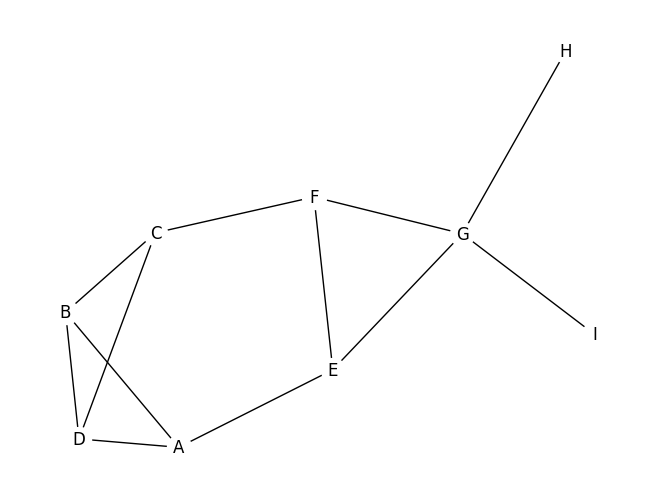

In [1]:
import networkx as nx

edges = [('A','B'),('A','D'),('A','E'),('B','D'),('B','C'),('C','D'),('C','F'),
         ('E','F'),('E','G'),('F','G'),('G','H'),('G','I')]
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True, node_color='white')

### 1-1. `CN (Common Neighbors)`  
- $CN(x,y)=|N(x)\cap N(y)|$  
    where $x,y$ : nodes and $N(x), N(y)$ : neighborhoods of $x,y$ (respectively)  
  
- [예] $CN(A,C)=|\{B,D\}|=2$  
  
- 알고리즘 순서  
    a. 비연결 node pair 구하기  
  
    b. 거리 2인 경로 구하기  
    - 방법 : a 에서 구한 각 비연결 노드 pair에 대한 (1-hop) 이웃 노드를 거치면 거리 2인 경로  
    - `nx.common_neighbors(G, u, v)` where $G$ : undirected graph and $u,v$ : nodes  
    - https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
  
    c. 각 node pair 마다 길이 2인 경로의 개수 세기

In [11]:
## (1) CN (Common Neighbors) 
#### 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(G))
print(non_edges)

[('A', 'C'), ('A', 'I'), ('A', 'G'), ('A', 'F'), ('A', 'H'), ('C', 'E'), ('C', 'H'), ('C', 'I'), ('C', 'G'), ('D', 'I'), ('D', 'G'), ('D', 'E'), ('D', 'F'), ('D', 'H'), ('I', 'E'), ('I', 'F'), ('I', 'H'), ('I', 'B'), ('G', 'B'), ('E', 'H'), ('E', 'B'), ('F', 'H'), ('F', 'B'), ('H', 'B')]


In [13]:
#### 길이 2인 경로 구하기 : 
CN = {}
for s,t in non_edges:
    print(s,t, list(nx.common_neighbors(G,s,t))) 
## A-C는 경로 2개라는 거임 -> 길이 2인 경로가 가장 많음 

A C ['B', 'D']
A I []
A G ['E']
A F ['E']
A H []
C E ['F']
C H []
C I []
C G ['F']
D I []
D G []
D E ['A']
D F ['C']
D H []
I E ['G']
I F ['G']
I H ['G']
I B []
G B []
E H ['G']
E B ['A']
F H ['G']
F B ['C']
H B []


In [15]:
## (1) CN (Common Neighbors) 
# 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(G))
# print(non_edges)

# 공통이웃 수 count 딕셔너리 생성
common_neighbors_count = {}
for n1,n2 in non_edges:
    common_neighbors_count[(n1, n2)] = len(list(nx.common_neighbors(G, n1, n2)))
    # print(common_neighbors_count)
sorted(common_neighbors_count.items(), key=lambda x: x[1], reverse=True)

[(('A', 'C'), 2),
 (('A', 'G'), 1),
 (('A', 'F'), 1),
 (('C', 'E'), 1),
 (('C', 'G'), 1),
 (('D', 'E'), 1),
 (('D', 'F'), 1),
 (('I', 'E'), 1),
 (('I', 'F'), 1),
 (('I', 'H'), 1),
 (('E', 'H'), 1),
 (('E', 'B'), 1),
 (('F', 'H'), 1),
 (('F', 'B'), 1),
 (('A', 'I'), 0),
 (('A', 'H'), 0),
 (('C', 'H'), 0),
 (('C', 'I'), 0),
 (('D', 'I'), 0),
 (('D', 'G'), 0),
 (('D', 'H'), 0),
 (('I', 'B'), 0),
 (('G', 'B'), 0),
 (('H', 'B'), 0)]

### 1-2. `Jaccard Coefficient (- index, - similarity)`  
- $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
- [예] $J(A,C)=\frac{|\{B,D\}|}{|\{B,D,E,F\}|}=\frac{2}{4}=0.5$  
  
- `nx.jaccard_coefficient(G, ebunch=None)`  where `ebunch` : iterable of node pairs, optional (default = None)  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient 

In [22]:
## (2) Jaccard
jaccard = list(nx.jaccard_coefficient(G))
print('unsorted jaccard index :\n%s' % jaccard)
jaccard = sorted(jaccard, key=lambda x: x[2], reverse=True)  
print('---------------------------------------------------')
# jaccard.sort(key=lambda x: x[2], reverse=True)  
# print('Jaccard = %s' % jaccard)
for u,v,j in jaccard:
    print(f"({u},{v}) -> {j}")#:.8f}")

unsorted jaccard index :
[('A', 'C', 0.5), ('A', 'I', 0.0), ('A', 'G', 0.16666666666666666), ('A', 'F', 0.2), ('A', 'H', 0.0), ('C', 'E', 0.2), ('C', 'H', 0.0), ('C', 'I', 0.0), ('C', 'G', 0.16666666666666666), ('D', 'I', 0.0), ('D', 'G', 0.0), ('D', 'E', 0.2), ('D', 'F', 0.2), ('D', 'H', 0.0), ('I', 'E', 0.3333333333333333), ('I', 'F', 0.3333333333333333), ('I', 'H', 1.0), ('I', 'B', 0.0), ('G', 'B', 0.0), ('E', 'H', 0.3333333333333333), ('E', 'B', 0.2), ('F', 'H', 0.3333333333333333), ('F', 'B', 0.2), ('H', 'B', 0.0)]
---------------------------------------------------
(I,H) -> 1.0
(A,C) -> 0.5
(I,E) -> 0.3333333333333333
(I,F) -> 0.3333333333333333
(E,H) -> 0.3333333333333333
(F,H) -> 0.3333333333333333
(A,F) -> 0.2
(C,E) -> 0.2
(D,E) -> 0.2
(D,F) -> 0.2
(E,B) -> 0.2
(F,B) -> 0.2
(A,G) -> 0.16666666666666666
(C,G) -> 0.16666666666666666
(A,I) -> 0.0
(A,H) -> 0.0
(C,H) -> 0.0
(C,I) -> 0.0
(D,I) -> 0.0
(D,G) -> 0.0
(D,H) -> 0.0
(I,B) -> 0.0
(G,B) -> 0.0
(H,B) -> 0.0


### 1-3. `RA, Resource Allocation (자원할당)`  
- $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
- [예] $RA(A,C)=\frac{1}{|N(B)|}+\frac{1}{|N(D)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
    - $N(A)\cap N(C)=\{B,D,E\}\cap \{B,D,F\}=\{B,D\}$
  
- `resource_allocation_index(G, ebunch=None)`
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html

In [23]:
## (3) RA, 자원 할당
resource = list(nx.resource_allocation_index(G))
resource = sorted(resource, key=lambda x: x[2], reverse=True)
for u,v,r in resource:
    print(f"({u},{v}) -> {r}")

(A,C) -> 0.6666666666666666
(A,G) -> 0.3333333333333333
(A,F) -> 0.3333333333333333
(C,E) -> 0.3333333333333333
(C,G) -> 0.3333333333333333
(D,E) -> 0.3333333333333333
(D,F) -> 0.3333333333333333
(E,B) -> 0.3333333333333333
(F,B) -> 0.3333333333333333
(I,E) -> 0.25
(I,F) -> 0.25
(I,H) -> 0.25
(E,H) -> 0.25
(F,H) -> 0.25
(A,I) -> 0
(A,H) -> 0
(C,H) -> 0
(C,I) -> 0
(D,I) -> 0
(D,G) -> 0
(D,H) -> 0
(I,B) -> 0
(G,B) -> 0
(H,B) -> 0


### 1-4. `AA, Adamic Adar`  
- $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log|N(v)|}$  
  
- [예] $RA(A,C)=\frac{1}{\log|N(B)|}+\frac{1}{\log|N(D)|}=\frac{1}{\log 3}+\frac{1}{\log 3}=1.820478\ldots$  
  
- `resource_allocation_index(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html#networkx.algorithms.link_prediction.resource_allocation_index

In [24]:
## AA
aa = list(nx.adamic_adar_index(G))
aa = sorted(aa, key=lambda x: x[2], reverse=True)
for u,v,a in aa:
    print(f"({u},{v}) -> {a}")

(A,C) -> 1.8204784532536746
(A,G) -> 0.9102392266268373
(A,F) -> 0.9102392266268373
(C,E) -> 0.9102392266268373
(C,G) -> 0.9102392266268373
(D,E) -> 0.9102392266268373
(D,F) -> 0.9102392266268373
(E,B) -> 0.9102392266268373
(F,B) -> 0.9102392266268373
(I,E) -> 0.7213475204444817
(I,F) -> 0.7213475204444817
(I,H) -> 0.7213475204444817
(E,H) -> 0.7213475204444817
(F,H) -> 0.7213475204444817
(A,I) -> 0
(A,H) -> 0
(C,H) -> 0
(C,I) -> 0
(D,I) -> 0
(D,G) -> 0
(D,H) -> 0
(I,B) -> 0
(G,B) -> 0
(H,B) -> 0


### 1-5. `PA, Preferential Attachment, Barabasi Albert`
- $PA(x,y)=|N(x)||N(y)|$  
  
- [예] $PA(A,C)=|N(A)||N(C)|=3\times 3=9$  
  
- `preferential_attachment(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment

In [25]:
## (5) PA 
pref = list(nx.preferential_attachment(G))
pref = sorted(pref, key=lambda x: x[2], reverse=True)
for u,v,p in pref:
    print(f"({u},{v}) -> {p}")

(A,G) -> 12
(C,G) -> 12
(D,G) -> 12
(G,B) -> 12
(A,C) -> 9
(A,F) -> 9
(C,E) -> 9
(D,E) -> 9
(D,F) -> 9
(E,B) -> 9
(F,B) -> 9
(A,I) -> 3
(A,H) -> 3
(C,H) -> 3
(C,I) -> 3
(D,I) -> 3
(D,H) -> 3
(I,E) -> 3
(I,F) -> 3
(I,B) -> 3
(E,H) -> 3
(F,H) -> 3
(H,B) -> 3
(I,H) -> 1


## 2. 서로 다른 커뮤니티에서의 링크 예측 
- `networkx` 라이브러리 이용해서 계산하면 되므로 그래프만 만들면 됨
### 2-0. 예제 그래프 만들기 : 하나의 그래프에서 서로 다른 두 커뮤니티(즉, 두 부분그래프)를 다룰 것임 -> 위와 같은 그래프인데, 두 서브그래프로 나눠서 다룸 
- `community0 = [A,B,C,D]`  
- `community1 = [E,F,G,H,I]`

In [ ]:
# community0 = ['A','B','C','D']
# community1 = ['E','F','G','H','I']
# labels = dict(zip(list(range(8)), community0 + community1))
# # print(list(range(0,4)), list(range(4,9)))
# print(labels)

- node coloring 참고 : https://choiseokwon.tistory.com/172

In [4]:
# import networkx as nx
# import matplotlib.pyplot as plt

# G = nx.Graph()
# G.add_edge(1,2, weight=5)
# G.add_edge(1,3, weight=6)
# G.add_edge(1,4, weight=2)
# G.add_edge(2,4, weight=1)
# G.add_edge(1,4, weight=0.5)
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
# labels = nx.get_edge_attributes(G, 'weight')
# print(labels)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

NodeDataView({'A': {'community': 0}, 'B': {'community': 0}, 'D': {'community': 0}, 'E': {'community': 1}, 'C': {'community': 0}, 'F': {'community': 1}, 'G': {'community': 1}, 'H': {'community': 1}, 'I': {'community': 1}})

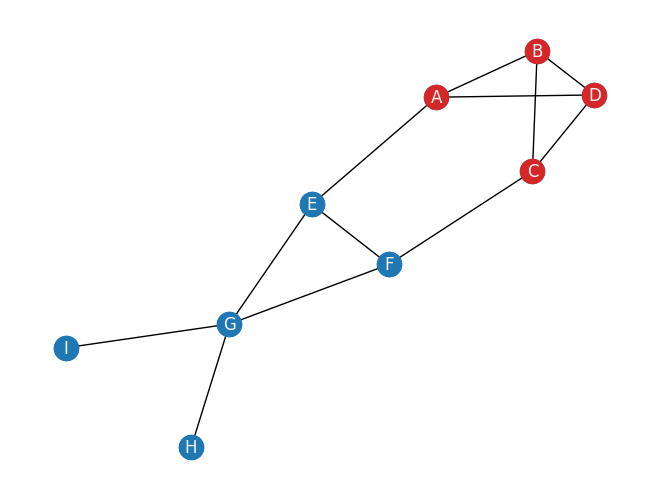

In [13]:
import networkx as nx

edges = [('A','B'),('A','D'),('A','E'),('B','D'),('B','C'),('C','D'),('C','F'),
        ('E','F'),('E','G'),('F','G'),('G','H'),('G','I')]
community0 = ['A','B','C','D'] ## 빨간색 노드
community1 = ['E','F','G','H','I'] ## 파란색 노드

G = nx.Graph()
G.add_edges_from(edges) 
pos = nx.spring_layout(G, seed=2023) ## positions for all nodes 
nx.draw(G, pos=pos, with_labels=True, font_color="whitesmoke") 
nx.draw_networkx_nodes(G, pos, ['A','B','C','D'], node_color="tab:red")
nx.draw_networkx_nodes(G, pos, ['E','F','G','H','I'], node_color="tab:blue")
G.add_nodes_from(community0, community=0)
G.add_nodes_from(community1, community=1)
G.nodes(data=True)

### 2-1. `Community CN (C.N. Soundarajan-Hopcroft score)`
- "the common neighbors Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CCN(x,y):=|N(x)\cap N(y)|+\sum_{v\in N(x)\cap N(y)}f(v)$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 공통 이웃의 수 $=|N(x)\cap N(y)| = CN(x,y)$  
  
    - 공통 이웃이 같은 커뮤니티에 속하는지의 여부 $=\sum_{v\in N(x)\cap N(y)}f(v)$ 
  
- [예1] $CCN(A,C)=CN(A,C)+\sum_{v\in\{B,D\}}f(v)=|\{B,D\}|+(f(B)+f(D))=2+(1+1)=4$  
  
- [예2] $CCN(F,I)=CN(F,I)+\sum_{v\in\{G\}}f(v)=|\{G\}|+f(G)=1+1=2$  
  
- `cn_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html

In [16]:
cn_s_h = list(nx.cn_soundarajan_hopcroft(G))
cn_s_h = sorted(cn_s_h, key=lambda x: x[2], reverse=True)
for u,v,csh in cn_s_h:
    print(f"({u}, {v}) -> {csh}")

(C, A) -> 4
(I, H) -> 2
(I, F) -> 2
(I, E) -> 2
(H, F) -> 2
(H, E) -> 2
(C, E) -> 1
(C, G) -> 1
(F, B) -> 1
(F, A) -> 1
(F, D) -> 1
(B, E) -> 1
(G, A) -> 1
(D, E) -> 1
(I, C) -> 0
(I, B) -> 0
(I, D) -> 0
(I, A) -> 0
(C, H) -> 0
(H, B) -> 0
(H, A) -> 0
(H, D) -> 0
(B, G) -> 0
(G, D) -> 0


### 2-2. `Community RA (Community Resource Allocation)`
- "the Resource Allocation Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CRA(x,y):=\sum_{v\in N(x)\cap N(y)}\frac{f(v)}{|N(v)|}$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 기존 RA 와 비슷하나, 분자에 1 대신 $f(v)$ -> 커뮤니티에 속했는지의 여부도 헤아림 
  
- [예1] $CRA(A,C)=\sum_{v\in\{B,D\}}\frac{f(v)}{|N(v)|}=\frac{f(B)}{|N(B)|}+\frac{f(D)}{|N(D)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
  
- [예2] $CRA(F,I)=\sum_{v\in\{G\}}\frac{f(v)}{|N(v)|}=\frac{1}{4}=0.25$  
  
- `ra_index_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft.html#networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft

In [17]:
ra_s_h = list(nx.ra_index_soundarajan_hopcroft(G))
ra_s_h = sorted(ra_s_h, key=lambda x: x[2], reverse=True)
for u,v,rsh in ra_s_h:
    print(f"({u}, {v}) -> {rsh}")

(C, A) -> 0.6666666666666666
(I, H) -> 0.25
(I, F) -> 0.25
(I, E) -> 0.25
(H, F) -> 0.25
(H, E) -> 0.25
(I, C) -> 0
(I, B) -> 0
(I, D) -> 0
(I, A) -> 0
(C, E) -> 0
(C, G) -> 0
(C, H) -> 0
(H, B) -> 0
(H, A) -> 0
(H, D) -> 0
(F, B) -> 0
(F, A) -> 0
(F, D) -> 0
(B, E) -> 0
(B, G) -> 0
(G, A) -> 0
(G, D) -> 0
(D, E) -> 0
